## Выделение атрибутов товара из текста описания 

Задача: выделение атрибутов товара из текста описания при помощи методов машинного обучения

Моя задача является одной из возможных задач NER(выделение именнованных сущностей из текста). 
За одной задачей NER, на самом деле, стоит две: 1) обнаружить, что какая-то последовательность слов — это именованная сущность; 2) понять, к какому классу  эта именованная сущность относится.  На каждом из этапов возникают свои сложности. Зачастую эта задача решается при помощи рекуррентных нейронных сетей, но я буду делать это исключительно методами машинного обучения. Мною были выбраны 4 модели: логистическая регрессия, случайный лес, дерево решений, градиентный бустинг(его реализация от Яндекса CatBoost).

Я буду использовать следующий подход:
1) разбиение названия(строки) на слова, т.е токенизация, и последующая нормализация
2) сформирую выборку, в которой каждое слово - отдельное наблюдение, модель будет классифицировать каждое слово по отдельности, используя эмбеддинги из библиотеки Navec


## Imports

In [1]:
import json
from yellowbrick.model_selection import ValidationCurve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from copy import deepcopy
from imblearn.over_sampling import RandomOverSampler
# Data manipulation libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score,KFold,StratifiedKFold,RepeatedStratifiedKFold,GridSearchCV
# Model evaluaion libraries
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report, f1_score, make_scorer
from imblearn.over_sampling import SMOTE
# Classiication Models libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier,plot_importance
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from navec import Navec
from sklearn.tree import DecisionTreeClassifier
import umap
# Remove warnings
import warnings
import pymorphy2
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None
RANDOM_STATE = 42
from sklearn.ensemble import VotingClassifier

In [23]:
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

## Preprocessing and Get Embeddings

Функция, которая разбивает словари, с парами 'ключ : метка' на отдельные строки 

In [16]:
def get_df(razmetka: pd.Series):
    data = pd.DataFrame(data = {'слова' : razmetka.apply(lambda x: x.keys()).explode(0).values,
                    'метки' : razmetka.apply(lambda x: x.values()).explode().values})
    data = data[data.метки != '-'][data.метки != '1']
    return data

In [17]:
def prepr(data : pd.DataFrame):
    data.метки = data.метки.apply(lambda x: 'бренд' if x in ['бред'] else x)
    data.метки = data.метки.apply(lambda x: 'наз' if x in ['назн'] else x)
    data.метки = data.метки.apply(lambda x: 'раз' if x in ['размер', 'разм'] else x)
    data.метки = data.метки.apply(lambda x: 'тов' if x in ['товар'] else x)
    data.метки = data.метки.apply(lambda x: 'мат' if x in ['материал'] else x)
    data.метки = data.метки.apply(lambda x: 'мод' if x in ['модель'] else x)

Разбивает один вектор эмбеддингов на разные столбцы

In [18]:
def get_features(X):
    
    for i in range(len(X.iloc[0, 0])):
        X[f'feat_{i+1}'] = X.Vec.apply(lambda x: x[i])
    X = X.drop('Vec', axis = 1)
    return X

In [19]:
preprocessed = pd.read_json('razmetka/01_05.json')

Как выглядит датасет после разметки

In [20]:
preprocessed[preprocessed.Razme4.notna()]

,Info,Norm_Title,Razme4
100,[Аквавошер Clean Cube Pro - генератор ПАВ быто...,"[аквавошер, clean, cube, рro, для, стиральный,...","{'аквавошер': 'тов', 'clean': 'бренд', 'cube':..."
101,[Жесткий диск 500 Гб],"[жёсткий, диск, 500, гб]","{'жёсткий': 'тов', 'диск': 'тов', '500': '-', ..."
102,"[Код: 287811, Артикул: 00FN113, Производитель:...","[жёсткий, диск, жёсткий, диск, 1x2tb, sata, га...","{'жёсткий': 'тов', 'диск': 'тов', '1x2tb': 'ра..."
103,[Заправка картриджа CF212A для техники моделей...,"[заправка, картридж, cf212a, hp]","{'заправка': 'тов', 'картридж': 'тов', 'cf212a..."
104,"[Заправка всех видов лазерных картриджей,ремон...","[заправка, картридж]","{'заправка': 'тов', 'картридж': 'тов'}"
...,...,...,...
80015,[Применяется со всеми типами ЛКМ.Рекомендуется...,"[валик, pro, line, 250, мм, ворс, 18, мм, d, 4...","{'валик': 'тов', 'pro': 'мод', 'line': 'мод', ..."
80016,"[Ворс кисти – искусственная щетина, расщепленн...","[кисть, макловица, 170, х, 70, мм, искусственн...","{'кисть': 'тов', 'макловица': 'мат', '170': 'р..."
80017,"[Ворс кисти макловицы – натуральная щетина, ра...","[кисть, макловица, 50, х, 150, мм, натуральный...","{'кисть': 'тов', 'макловица': 'мат', '50': 'ра..."
80018,[Артикул: 10089-30-06_z01 торговая марка: СИБИ...,"[шпатель, нержавеющий, сибин, зубчатый, с, пла...","{'шпатель': 'тов', 'нержавеющий': 'тип', 'сиби..."


In [23]:
preprocessed = pd.read_json('razmetka/01_05.json')
dataset = preprocessed[preprocessed.Razme4.notna()].Razme4 ## оставляем только размеченные
dataset = get_df(dataset)
prepr(dataset)
dataset = dataset[dataset.метки != 'цвет']
dataset['Vec'] = dataset.слова.apply(lambda x: navec.get(x)) ## получаем эмбеддинги
dataset = dataset[dataset.Vec.notna()]


In [24]:
dataset.метки.value_counts()

тов      211
тип       86
наз       62
мат       36
раз       30
бренд     14
мод       14
гор        3
гост       2
Name: метки, dtype: int64

In [18]:
dataset.метки.unique()

array(['бренд', 'наз', 'тов', 'раз', 'тип', 'мат', 'гор', 'гост', 'мод'],
      dtype=object)

Энкодинг получившихся меток c LabelEncoder и получение эмбеддингов.
Для получения эмбеддингов(размерности 300) использовалась библиотека Navec, но в ней были эмбеддинги не для всех слов. Те, которых не оказалось были убраны из выборки.

In [25]:
encoder = LabelEncoder()
y = encoder.fit_transform(dataset.метки)
X = dataset[['Vec']]
X = get_features(X)

In [26]:
pd.Series(y).value_counts(), dataset.метки.value_counts()

(8    211
 7     86
 5     62
 3     36
 6     30
 0     14
 4     14
 1      3
 2      2
 dtype: int64,
 тов      211
 тип       86
 наз       62
 мат       36
 раз       30
 бренд     14
 мод       14
 гор        3
 гост       2
 Name: метки, dtype: int64)

In [27]:
dict_ = dict(zip((list(pd.Series(y).value_counts().index)), list(dataset.метки.value_counts().index)))

In [36]:
dict_ словарь для составления соответствий

{8: 'тов',
 7: 'тип',
 5: 'наз',
 3: 'мат',
 6: 'раз',
 0: 'бренд',
 4: 'мод',
 1: 'гор',
 2: 'гост'}

In [22]:
assert X.values.shape[0]  == y.ravel().shape[0]

In [23]:
X.to_csv('clean_data/X.csv', index=False)
pd.Series(y).to_csv('clean_data/y.csv', index=False)

## Scatter after Umap

UMAP - метод понижения размерности, который возвращает вектор размерности 2

In [24]:
X_umaped = pd.read_csv('clean_data/X_umaped.csv')


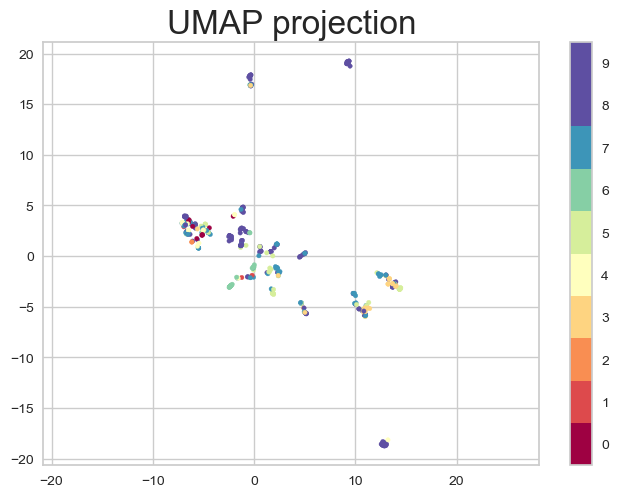

In [25]:
plt.scatter(X_umaped.loc[:, '0'], X_umaped.loc[:, '1'], c=data.метки.unique(), cmap='Spectral', s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection', fontsize=24);

 По данному скаттерплоту, что какие-то точки разделяются очевидно, другие же нет.

### Classes to get first models

Класс для кроссвалидации внутри models_summary 

In [8]:
class Splitter:
    def __init__(self, kfold = True, n_repeats = None, n_splits = 5, shuffle = True):
        self.kfold = kfold
        self.n_repeats = n_repeats
        self.n_splits = n_splits
        self.shuffle = shuffle
        
    def split_data(self, X, y):
        if self.n_repeats:
            kf = RepeatedStratifiedKFold(n_repeats = self.n_repeats, n_splits = self.n_splits, shuffle = self.shuffle)
        
        else:
            kf = StratifiedKFold(n_splits = self.n_splits, shuffle = self.shuffle)
        
        for train_idx, val_idx in kf.split(X, y):
            X_train, X_val = X[train_idx, :], X[val_idx, :]
            y_train, y_val = y[train_idx], y[val_idx]
            yield X_train, X_val, y_train, y_val
    

Класс получения начальных моделей

In [9]:
class models_summary():
    def __init__(self, classifiers =  {'SVC':SVC(), 
                            'RF':RandomForestClassifier(), 
                            'CatBoost':CatBoostClassifier(silent=True), 
                            'LogReg':LogisticRegression()}):
        self.classifiers = classifiers
        self.cv_results = dict(zip(list(self.classifiers.keys()), [None] * len(self.classifiers))) 
         
        self.holdout_results = dict(zip(list(self.classifiers.keys()), [None] * len(self.classifiers)))
                
        
    def fit(self, X_ : np.array, y_ : np.array, holdout_size = 0.2, random_state = None, n_splits = 5):
        self.n_splits = n_splits
        self.holdout_size = holdout_size
        self.X, self.X_holdout, self.y, self.y_holdout = train_test_split(X_, y_,\
                                                                          test_size=self.holdout_size, stratify = y_)

        for classifier_name in list(self.classifiers.keys()):
            splitter = Splitter(n_splits=self.n_splits)
            model = self.classifiers[classifier_name]
            self.cv_results[classifier_name] = []
            for X_train, X_val, y_train, y_val in splitter.split_data(self.X, self.y):
                model.fit(X_train, y_train)
                score = model.score(X_val, y_val)
                self.cv_results[classifier_name].append(score)

            holdout_score = model.score(self.X_holdout, self.y_holdout)
            self.holdout_results[classifier_name] = holdout_score

            print(f'{classifier_name} fitted,\nHoldout Result = {holdout_score}')
        return pd.DataFrame({'model_name' : list(self.classifiers.keys()),
                            'holdout_score' : list(self.holdout_results.values())})

        
        
        
        

In [10]:
summary = models_summary()
df = summary.fit(X.values, y, n_splits = 4)

SVC fitted,
Holdout Result = 0.75
RF fitted,
Holdout Result = 0.7282608695652174
CatBoost fitted,
Holdout Result = 0.7282608695652174
LogReg fitted,
Holdout Result = 0.782608695652174


## Split Data

Разделение выборки на тренировочную и отложенную

In [23]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size = 0.2)

In [25]:
pd.DataFrame(X_train).to_csv('clean_data/X_train.csv')
pd.DataFrame(X_holdout).to_csv('clean_data/X_holdout.csv')
pd.DataFrame(y_train).to_csv('clean_data/y_train.csv')
pd.DataFrame(y_holdout).to_csv('clean_data/y_holdout.csv')

In [2]:
X_train = pd.read_csv('clean_data/X_train.csv', index_col=0)
y_train = pd.read_csv('clean_data/y_train.csv', index_col=0)
y_holdout = pd.read_csv('clean_data/y_holdout.csv', index_col=0)
X_holdout = pd.read_csv('clean_data/X_holdout.csv', index_col=0)

## Grids

Сетки для последующего гридсерча

In [42]:
n_samples = X.shape[0]
n_features = X.shape[1]

In [78]:
RF_grid = { 
    'n_estimators': [150, 175, 200, 225, 250, 275, 300],
    'max_features': ['sqrt'],
    'max_depth' : [7,8, 9, 10, 11],
}
CatBoost_grid = {'depth'         : [4,5,6,7,8],
                 'learning_rate' : [0.01,0.02,0.03,0.04],
                  'iterations'    : [10, 20,30,40,50,60,70]
                 }

logreg_grid = {'penalty' : ['l2', 'l1'],
               'C' : [0.25, 0.5, 0.8, 1]
}


DecisionTree_grid ={
                    'max_depth': [6,7,8,9,10,11,12,13],
                    'max_features': ['sqrt','log2', 0.3,0.5,0.7, n_features//2, n_features//3],
                    'min_samples_split': [2,0.3,0.5, n_samples//2, n_samples//3, n_samples//5],
                    'min_samples_leaf':[1, 0.3,0.5, n_samples//2, n_samples//3, n_samples//5]}

## GridSearch

In [79]:
estimators = {RandomForestClassifier() : [RF_grid, 'RF'], 
              LogisticRegression() : [logreg_grid, 'LogReg'],
            DecisionTreeClassifier() : [DecisionTree_grid, 'Tree']}
names = ['RF', 'LogReg', 'Tree']
f1_macro= make_scorer(f1_score, average = 'macro')
cv = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)

Провожу поиск оптимальных гиперпараметров по сетке(GridSearch), используя в качестве скора f1 macro, так как надо учитывать f1 по всем классам.
Все результаты кросс-валидации и параметры лучших моделей сохраняются в json файлы

In [80]:
data= {}
for estimator, grid in list(estimators.items()):
    gridsearch = GridSearchCV(estimator=estimator, param_grid=grid[:-1], scoring=f1_macro, cv=cv)
    gridsearch.fit(X_train, y_train)
    print(f'{grid[-1]} Fitted\nBest Score:{gridsearch.best_score_}')
    data[grid[-1]] = gridsearch.best_score_
    
    pd.DataFrame(gridsearch.cv_results_).to_json(f'cv_results/{grid[-1]}_results.json')
    print(f'File cv_results/{grid[-1]}_results.json written!')
    pd.DataFrame(gridsearch.best_params_, index = [1]).to_json(f'cv_results/{grid[-1]}_best_params.json', index=False, orient='table')
    print(f'File cv_results/{grid[-1]}_best_params.json written')
    print('-'*30)

RF Fitted
Best Score:0.5829846053766348
File cv_results/RF_results.json written!
File cv_results/RF_best_params.json written
------------------------------


d:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
16 fits failed out of a total of 32.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "d:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "d:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or 'none' pen

LogReg Fitted
Best Score:0.6011481004134294
File cv_results/LogReg_results.json written!
File cv_results/LogReg_best_params.json written
------------------------------
Tree Fitted
Best Score:0.5734620543307978
File cv_results/Tree_results.json written!
File cv_results/Tree_best_params.json written
------------------------------


### Get DataFrame

In [56]:
pd.read_json('cv_results/Tree_results.json').loc[:, ['params', 'mean_test_score', 'std_test_score']].sort_values(by = 'mean_test_score', ascending=False).head(10)

,params,mean_test_score,std_test_score
1764,"{'max_depth': 12, 'max_features': 'auto', 'min...",0.568837,0.085495
1512,"{'max_depth': 11, 'max_features': 'log2', 'min...",0.542773,0.085256
1980,"{'max_depth': 12, 'max_features': 100, 'min_sa...",0.541725,0.074352
1296,"{'max_depth': 10, 'max_features': 0.5, 'min_sa...",0.540830,0.072160
2160,"{'max_depth': 13, 'max_features': 0.5, 'min_sa...",0.539983,0.042873
1584,"{'max_depth': 11, 'max_features': 0.5, 'min_sa...",0.539467,0.071232
1116,"{'max_depth': 9, 'max_features': 100, 'min_sam...",0.532386,0.084043
1260,"{'max_depth': 10, 'max_features': 0.3000000000...",0.528163,0.050259
504,"{'max_depth': 7, 'max_features': 150, 'min_sam...",0.524261,0.038343
792,"{'max_depth': 8, 'max_features': 150, 'min_sam...",0.514868,0.070929


In [57]:
pd.read_json('cv_results/LogReg_results.json').loc[:, ['params', 'mean_test_score', 'std_test_score']].sort_values(by = 'mean_test_score', ascending=False).head(10)

,params,mean_test_score,std_test_score
0,"{'C': 0.25, 'penalty': 'l2'}",0.601148,0.070753
4,"{'C': 0.8, 'penalty': 'l2'}",0.600156,0.081289
2,"{'C': 0.5, 'penalty': 'l2'}",0.598790,0.078667
6,"{'C': 1, 'penalty': 'l2'}",0.597833,0.079014
1,"{'C': 0.25, 'penalty': 'l1'}",NaN,NaN
3,"{'C': 0.5, 'penalty': 'l1'}",NaN,NaN
5,"{'C': 0.8, 'penalty': 'l1'}",NaN,NaN
7,"{'C': 1, 'penalty': 'l1'}",NaN,NaN


In [58]:
pd.read_json('cv_results/RF_results.json').loc[:, ['params', 'mean_test_score', 'std_test_score']].sort_values(by = 'mean_test_score', ascending=False).head(20)

,params,mean_test_score,std_test_score
17,"{'max_depth': 9, 'max_features': 'sqrt', 'n_es...",0.572496,0.050112
0,"{'max_depth': 7, 'max_features': 'sqrt', 'n_es...",0.571550,0.063041
26,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",0.570467,0.058160
22,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",0.570010,0.051996
19,"{'max_depth': 9, 'max_features': 'sqrt', 'n_es...",0.569284,0.061374
9,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...",0.568374,0.044902
8,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...",0.566905,0.052895
31,"{'max_depth': 11, 'max_features': 'sqrt', 'n_e...",0.566868,0.064875
10,"{'max_depth': 8, 'max_features': 'sqrt', 'n_es...",0.566803,0.063710
28,"{'max_depth': 11, 'max_features': 'sqrt', 'n_e...",0.566547,0.055017


## Best Models

Функция, которая получает названия папки, в которой лежат json файлы с лучшими параметрами, и возвращает список соотвствующих моделей

In [2]:
def get_models_by_params_json(path:str):
    params = []
    names = ['RF', 'LogReg', 'Tree']
    for name in names:
        with open(f'cv_results/{name}_best_params.json') as project_file:    
            data = json.load(project_file)  
            params.append(pd.json_normalize(data).data[0][0])
    estimators = [RandomForestClassifier, LogisticRegression, DecisionTreeClassifier]
    estimators = dict(zip(['RF','LogReg', 'Tree'], estimators))
    params = dict(zip(['RF','LogReg', 'Tree'], params))
    estimators = list(map(lambda x: estimators[x](**params[x]),estimators.keys()))
    return estimators

In [103]:
estimators = get_models_by_params_json('cv_results')
estimators



[RandomForestClassifier(max_depth=9, n_estimators=175),
 LogisticRegression(C=0.25),
 DecisionTreeClassifier(max_depth=13, max_features=0.7)]

In [86]:
names = ['RF', 'LogReg', 'Tree']

## Best Models Perfomance on Holdout

Функция, которая получает список моделей и возвращает датафрейм с результатами на отложенной выборке

In [41]:
def models_perfomance(estimators, oversampled = False):
    results = {}
    for i in range(len(estimators)):
        if not oversampled:
            estimators[i].fit(X_train, y_train)
        else:
            estimators[i].fit(oversampled_X, oversampled_y)
        pred = estimators[i].predict(X_holdout)
        print(f'{names[i]} f1_score = {f1_score(pred, y_holdout, average="macro")}\n{classification_report(pred, y_holdout)}\n{"-"*30}')
        results[names[i]] = f1_score(pred, y_holdout, average="macro")
    return pd.DataFrame(results, index = ['f1_macro'])

In [44]:
holdout_results = models_perfomance(estimators)


RF f1_score = 0.5555652680652681
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.00      0.00      0.00         0
           3       0.57      0.80      0.67         5
           4       0.33      1.00      0.50         1
           5       0.60      0.82      0.69        11
           6       0.80      0.80      0.80         5
           7       0.42      0.67      0.51        15
           8       1.00      0.63      0.77        54

    accuracy                           0.68        92
   macro avg       0.51      0.71      0.56        92
weighted avg       0.81      0.68      0.71        92

------------------------------
LogReg f1_score = 0.5363571187584345
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.00      0.00      0.00         0
           3       0.57      0.67      0.62         6
           4       0.33      0.

In [45]:
holdout_results

,RF,LogReg,Tree
f1_macro,0.555565,0.536357,0.504699


### CatBoost

CatBoost я обучал отдельно, так как на это требовалось много времени, ячейка с сами гридсерчем утеряна, сохранил JSON файс с лучшими параметрами

In [46]:
best_cb = CatBoostClassifier(**pd.read_json('cv_results/CatBoost_best_params.json').to_dict(orient='records')[0])

In [ ]:
best_cb.fit(X_train, y_train)
pred = best_cb.predict(X_holdout)
print(f'CatBoost f1_score = {f1_score(pred, y_holdout, average="macro")}\n{classification_report(pred, y_holdout)}\n{"-"*30}')
holdout_results['CatBoost'] = f1_score(pred, y_holdout, average="macro")

In [48]:
holdout_results_before_oversampling = holdout_results

In [50]:
holdout_results_before_oversampling


,RF,LogReg,Tree,CatBoost
f1_macro,0.555565,0.536357,0.504699,0.552551


In [51]:
holdout_results_before_oversampling.to_json('holdout_results/before_oversampling.json')

Здесь мы видим явное преимущество случайного леса.

## Validation Curves


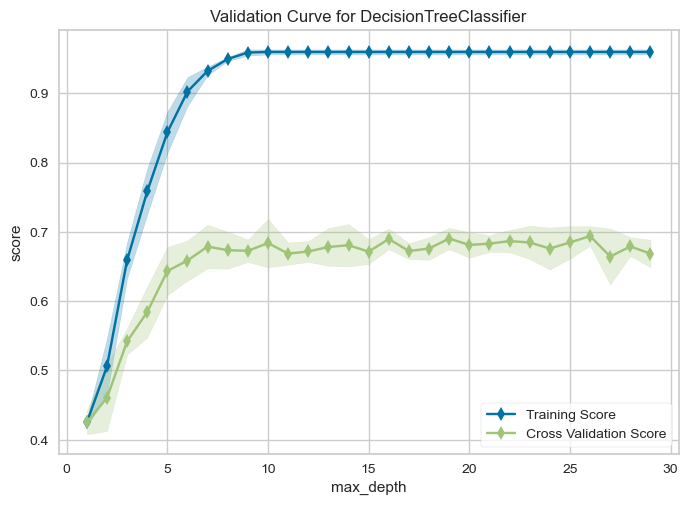

<Axes: title={'center': 'Validation Curve for DecisionTreeClassifier'}, xlabel='max_depth', ylabel='score'>

In [382]:
viz = ValidationCurve(
    DecisionTreeClassifier(), param_name="max_depth",
    param_range=np.arange(1, 30), cv=cv, scoring=f1_weighted
)
viz.fit(X_train, y_train)
viz.show()

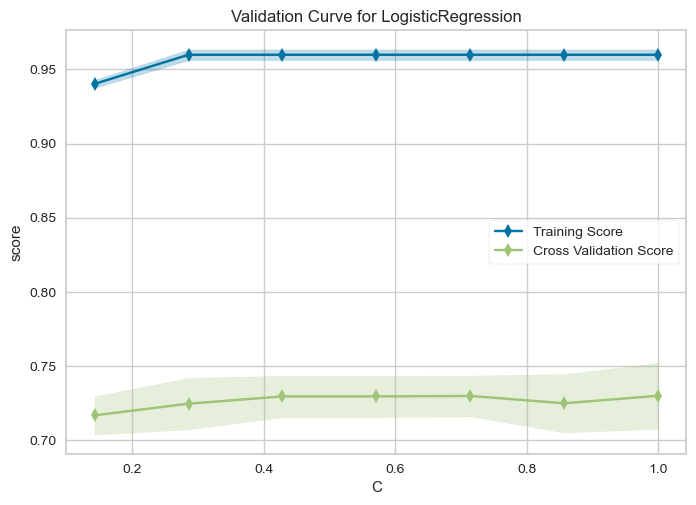

<Axes: title={'center': 'Validation Curve for LogisticRegression'}, xlabel='C', ylabel='score'>

In [379]:
viz = ValidationCurve(
    LogisticRegression(penalty='l2'), param_name="C",
    param_range=np.linspace(0, 1, 8), cv=cv, scoring=f1_weighted
)
viz.fit(X_train, y_train)
viz.show()

## Oversampling

В выборке присутствует сильный дисбаланс классов, поэтому я решил использовать оверсэмплинг для того, чтобы сбалансировать выборку

Оверсэмплиться будет только обучающая выборка, баланс классов в холдауте останется прежним.


In [27]:
oversampler = RandomOverSampler()
oversampled_X, oversampled_y = oversampler.fit_resample(X_train, y_train)

In [58]:
oversampled_X.to_csv('clean_data/oversampled_X.csv', index = False)
oversampled_y.to_csv('clean_data/oversampled_y.csv', index = False)

In [17]:
oversampled_X = pd.read_csv('clean_data/oversampled_X.csv')
oversampled_y = pd.read_csv('clean_data/oversampled_y.csv')

Баланс классов до оверсэмплинга:

In [92]:
y_train.value_counts()

0
8    177
7     62
5     47
3     29
6     25
0     11
4     11
1      2
2      2
dtype: int64

После оверсэмплинга:

In [96]:
oversampled_y.value_counts()

0
0    177
1    177
2    177
3    177
4    177
5    177
6    177
7    177
8    177
dtype: int64

In [123]:
n_samples = oversampled_X.shape[0]

In [124]:
RF_grid = { 
    'n_estimators': [150, 175, 200, 225, 250, 275, 300],
    'max_features': ['sqrt'],
    'max_depth' : [6, 7,8, 9, 10, 11, 12, 13, 14, 15, 16],
}
CatBoost_grid = {'depth'         : [4,5,6,7,8, 10, 11, 12],
                 'learning_rate' : [0.01,0.02,0.03,0.04],
                  'iterations'    : [10, 20,30,40,50,60,70]
                 }

logreg_grid = {'penalty' : ['l2', 'l1'],
               'C' : [0.25, 0.3, 0.4, 0.5, 0.6, 0.7,  0.8, 1]
}


DecisionTree_grid ={
                    'max_depth': [6,7,8,9,10,11,12,13],
                    'max_features': ['sqrt','log2', 0.3,0.5,0.7, n_features//2, n_features//3],
                    'min_samples_split': [2,0.3,0.5, n_samples//2, n_samples//3, n_samples//5],
                    'min_samples_leaf':[1, 0.3,0.5, n_samples//2, n_samples//3, n_samples//5]}

In [125]:
estimators = {RandomForestClassifier() : [RF_grid, 'RF'], 
#              CatBoostClassifier() : CatBoost_grid, 
              LogisticRegression() : [logreg_grid, 'LogReg'],
            DecisionTreeClassifier() : [DecisionTree_grid, 'Tree']}
names = ['RF', 'LogReg', 'Tree']

In [126]:
for estimator, grid in list(estimators.items()):
    gridsearch = GridSearchCV(estimator=estimator, param_grid=grid[:-1], scoring='f1_macro', cv=cv) ## создание объекта гридсерча, передача сеток параметров, кросс-валидации на 4 фолдах
    gridsearch.fit(oversampled_X, oversampled_y)
    print(f'{grid[-1]} Fitted\nBest Score:{gridsearch.best_score_}')

    ### запись результатов кросс-валидации и параметров лучших моделей в JSON файлы
    pd.DataFrame(gridsearch.cv_results_).to_json(f'oversampled_cv_results/{grid[-1]}_results.json')
    print(f'File cv_results/{grid[-1]}_results.json written!')
    pd.DataFrame(gridsearch.best_params_, index = [1]).to_json(f'oversampled_cv_results/{grid[-1]}_best_params.json', index=False, orient='table')
    print(f'File cv_results/{grid[-1]}_best_params.json written')
    print('-'*30)

RF Fitted
Best Score:0.9663684228026392
File cv_results/RF_results.json written!
File cv_results/RF_best_params.json written
------------------------------


d:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
32 fits failed out of a total of 64.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
32 fits failed with the following error:
Traceback (most recent call last):
  File "d:\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "d:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or 'none' pen

LogReg Fitted
Best Score:0.9564374022883184
File cv_results/LogReg_results.json written!
File cv_results/LogReg_best_params.json written
------------------------------
Tree Fitted
Best Score:0.9512974441965443
File cv_results/Tree_results.json written!
File cv_results/Tree_best_params.json written
------------------------------


## Models Fitted on Oversampled Data Perfomance on Holdout

In [12]:
oversampled_estimators = get_models_by_params_json('oversampled_cv_results')
oversampled_estimators

[RandomForestClassifier(max_depth=9, n_estimators=175),
 LogisticRegression(C=0.25),
 DecisionTreeClassifier(max_depth=13, max_features=0.7)]

In [17]:
oversampled_holdout_results = models_perfomance(oversampled_estimators, oversampled=True)

RF f1_score = 0.5523269575748155
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.00      0.00      0.00         0
           3       0.57      0.57      0.57         7
           4       0.33      0.50      0.40         2
           5       0.67      0.83      0.74        12
           6       1.00      0.71      0.83         7
           7       0.62      0.79      0.70        19
           8       0.94      0.76      0.84        42

    accuracy                           0.74        92
   macro avg       0.56      0.56      0.55        92
weighted avg       0.78      0.74      0.75        92

------------------------------
LogReg f1_score = 0.57806062327715
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.00      0.00      0.00         0
           3       0.57      0.50      0.53         8
           4       0.33      0.50

In [18]:
oversampled_holdout_results

,RF,LogReg,Tree
f1_macro,0.552327,0.578061,0.493745


После оверсэмплинга у логистической модели и дерева решений увеличился f1_macro, в то время как у случайного леса не изменился. Могу предположить, что это связано с тем, что при построении каждого дерева в случайном лесе производится случайная выборка с повторениями, что само по себе может бороться с дисбалансом классов.

### Catboost After Oversampling on Holdout

In [134]:
catboost = CatBoostClassifier(loss_function='MultiClass')

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10]}
PARAMS = {
"iterations": [50, 60, 70, 80, 90, 100],
"learning_rate": [0.02, 0.03, 0.05, 0.1, 0.15],
"max_depth": np.arange(4, 10)}


Мультиклассом в кэтбусте называется обычная кросс-энтропия

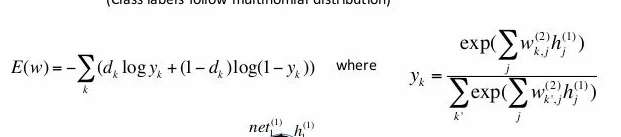

In [ ]:
catboost.grid_search(PARAMS, oversampled_X, oversampled_y,plot=True, refit=True, cv=cv)

In [104]:
pred = catboost.predict(X_holdout)
print(f'CatBoost f1_score = {f1_score(pred, y_holdout, average="macro")}\n{classification_report(pred, y_holdout)}\n{"-"*30}')

CatBoost f1_score = 0.5462116502006976
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.00      0.00      0.00         0
           3       0.57      0.67      0.62         6
           4       0.33      1.00      0.50         1
           5       0.60      0.64      0.62        14
           6       1.00      0.71      0.83         7
           7       0.58      0.74      0.65        19
           8       0.91      0.74      0.82        42

    accuracy                           0.71        92
   macro avg       0.54      0.60      0.55        92
weighted avg       0.76      0.71      0.72        92

------------------------------


In [140]:
pd.DataFrame(catboost.get_params(), index = [1]).to_json(f'oversampled_cv_results/CatBoost_results.json')

In [ ]:
catboost = CatBoostClassifier(**pd.read_json('oversampled_cv_results/CatBoost_results.json', orient='records')[0])

In [21]:
oversampled_holdout_results

,RF,LogReg,Tree,CatBoost
f1_macro,0.552327,0.578061,0.493745,0.55


## Blending Ensemble

Далее я решил построить еще одну модель, а именно блендинговый ансамбль. Его идея в том, что мы берем предсказания наших базовых моделей, которыми в моем случаи выступали логистическая регрессия, случайный лес, дерево решений и градиентный бустинг(CatBoost), в качестве признаков для "блендера". По итогу модель получает на вход 4-мерные векторы. Блендером служит модель логистической регрессии. Важно отметить, что по итогу получается 3 выборки, т.е. изначальная трейн выборка бьется на две и мы получаем следующее:
- X_train, y_train - выборка, на которой учатся базовые модели.
- X_test, y_test - выборка, на которой базовые модели делают предсказания, которые далее идут в блендер в качестве признаков
- X_holdout, y_holdout - изначальные отложенные выборки

Также важно, что train и test выборки подаются после оверсэмплинга, holdout выборка все так же остается не тронутой.

In [22]:
models_for_ensemble = get_models_by_params_json('oversampled_cv_results')

In [23]:
catboost = CatBoostClassifier(**pd.read_json('oversampled_cv_results/CatBoost_results.json').to_dict(orient='records')[0])

In [24]:
models_for_ensemble.append(catboost)

In [25]:
from classifier import ensemble

In [ ]:
my_ensemble = ensemble(models_for_ensemble)
my_ensemble.fit(oversampled_X, oversampled_y)
pred = my_ensemble.predict(X_holdout)


In [27]:
print(classification_report(pred, y_holdout))

              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.00      0.00      0.00         0
           3       0.57      0.50      0.53         8
           4       0.33      0.50      0.40         2
           5       0.80      0.60      0.69        20
           6       1.00      0.50      0.67        10
           7       0.46      0.73      0.56        15
           8       0.79      0.82      0.81        33

    accuracy                           0.67        92
   macro avg       0.58      0.52      0.53        92
weighted avg       0.73      0.67      0.68        92



In [28]:
oversampled_holdout_results['Blending Ensemble'] = f1_score(pred, y_holdout, average='macro')

In [29]:
oversampled_holdout_results

,RF,LogReg,Tree,CatBoost,Blending Ensemble
f1_macro,0.552327,0.578061,0.493745,0.55,0.528402


## Voting Classifier

Также я решил попробовать другой вид ансамбля, а именно Voting Classifier. Работает он по следующему принципу: каждя из моделей первой уровня делает свой предикт по отложенной выборке, после чего проходит "голосование", т.е. модель ансамблевая модель возвращает тот класс, который предсказало большее кол-во базовых моделей

In [30]:
models_for_ensemble = get_models_by_params_json('oversampled_cv_results')
catboost = CatBoostClassifier(**pd.read_json('oversampled_cv_results/CatBoost_results.json').to_dict(orient='records')[0])
models_for_ensemble.append(catboost)

In [31]:

RF = models_for_ensemble[0]
LogReg = models_for_ensemble[1]
Tree = models_for_ensemble[2]
CatBoost = models_for_ensemble[3]

In [32]:
voting_ensemble = VotingClassifier(estimators = [('Random Forest', RF), ('LogReg', LogReg), ('DecTree', Tree), ('CatBoost', CatBoost)], voting = 'soft')

In [ ]:
voting_ensemble.fit(oversampled_X, oversampled_y)
pred = voting_ensemble.predict(X_holdout)


In [34]:
print(classification_report(pred, y_holdout))

              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.00      0.00      0.00         1
           3       0.57      0.57      0.57         7
           4       0.33      0.25      0.29         4
           5       0.60      0.69      0.64        13
           6       1.00      0.56      0.71         9
           7       0.67      0.84      0.74        19
           8       0.91      0.82      0.86        38

    accuracy                           0.73        92
   macro avg       0.55      0.59      0.54        92
weighted avg       0.76      0.73      0.73        92



In [35]:
oversampled_holdout_results['Voting'] = f1_score(pred, y_holdout, average= 'macro')

## Результаты всех моделей

До оверсэмплинга

In [52]:
holdout_results_before_oversampling

,RF,LogReg,Tree,CatBoost
f1_macro,0.555565,0.536357,0.504699,0.552551


После оверэмплинга

In [53]:
oversampled_holdout_results

,RF,LogReg,Tree,CatBoost,Blending Ensemble,Voting
f1_macro,0.552327,0.578061,0.493745,0.55,0.528402,0.539948


Видно, что сильно улучшился результат логистическое регрессии, но не стоит забывать, что это скор лишь на одной выборке, то есть это может быть частным случаем.
Поэтому за основу своего классификатора возьму блендинг ансамбль, который будет более стабилен, так как он принимает во внимание ответы всех моделей.

## Демонстрация работы модели

In [78]:
class ensemble():
    def __init__(self, models: list):
        self.models = models
        self.blender = LogisticRegression()  ## инициализация блендера 
    def fit(self, X, y):
        meta_X = list()         

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
        for model in self.models:
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            pred = pred.reshape(len(pred), 1)
            meta_X.append(pred)
        meta_X = np.hstack(meta_X)
        self.blender.fit(X_test, y_test)
        
    
    def predict(self, X):
        pred = self.blender.predict(X)
        return pred


class classifier():
    def __init__(self,models):
        self.models = models
        self.morph = pymorphy2.MorphAnalyzer()
        self.metki = pd.read_json('metki.json').to_dict(orient='records')[0]
        self.ensemble = ensemble(self.models)
        X = pd.read_csv('clean_data/oversampled_X.csv')
        y = pd.read_csv('clean_data/oversampled_y.csv')
        self.ensemble.fit(X, y)

    def predict(self, x:str):
        list_ = x.split()
        pred_dict = {}

        for word in list_:
            if word.isdigit() or word.isascii(): ## присваивает класс модели, если только цифры или только буквы английского алфавита
                pred_dict[word] = self.metki[4]
            
            elif re.search(r'\dx\d', word) or re.search(r'\dx\dx\d', word) or re.search(r'\d*\d', word): # регулярка на проверку размера
                pred_dict[word] = self.metki[6]


            else:
                x = self.morph.parse(word.lower())[0].normalized.word
                if isinstance(navec.get(x), np.ndarray):
                    x = navec.get(x)
                    pred = self.ensemble.predict(x.reshape(1, -1))
                    pred_dict[word] = self.metki[pred[0]]
                else:
                    pred_dict[word] = 'unik'
        return pred_dict
        

In [79]:
my_clf = classifier(models_for_ensemble)
data = pd.read_json('data/9_parsed.json')
data = data.Title

In [80]:
for i in range(20, 30):
    print(my_clf.predict(data[i]))


{'Автомобильные': 'наз', 'коврики': 'наз', 'в': 'раз', 'салон.': 'unik'}
{'Автомобильный': 'наз', 'держатель': 'наз', 'мобильного': 'тов', 'телефона': 'тов', 'Zipower': 'мод', 'PM6616': 'мод'}
{'Автомобильный': 'наз', 'держатель': 'наз', 'Wiiix': 'мод', 'универсальный': 'тип', 'HT-S3': 'мод', 'черный': 'тип'}
{'Щетка': 'тип', 'стеклоочистителя': 'тип', 'бескаркасная': 'unik', 'AWM': 'мод', 'B': 'мод', '22': 'мод', 'R': 'мод'}
{'Органайзер': 'тип', 'автомобильный': 'наз', 'в': 'раз', 'багажник': 'тов', 'складной': 'тип', 'STELS': 'мод', '54395': 'мод'}
{'Тягово-сцепное': 'unik', 'устройство': 'тов', '(беззазорное)^21-202': 'раз', '(21-324)ТЕХНОТРОН': 'раз'}
{'Щетка': 'тип', 'стеклоочистителя': 'тип', 'бескаркасная': 'unik', '11in1': 'мод', '550mm': 'мод', '22"': 'мод'}
{'Щетка': 'тип', 'стеклоочистителя': 'тип', 'Subaru': 'мод', 'soa591u217r': 'мод'}
{'Подкрылок': 'unik', 'прав.': 'unik', 'пер.': 'unik'}
{'Автомобильный': 'наз', 'держатель': 'наз', 'Remax': 'мод'}


## Вывод

Модели машинного обучения не показали хороших результатов в решении задачи NER, если их сравнивать с решениями, которые сейчас применяются на практике(рекуррентные нейронные сети). В целом, это неудивительно, ведь как я сказал в введении задача NER состоит из двух:
1) обнаружить, что какая-то последовательность слов — это именованная сущность; 
2) понять, к какому классу  эта именованная сущность относится.
Модели машинного обучения не могут справиться с первой частью этой задачи, так как рассматривают каждое слово как отдельное наблюдения, не смотря на контекст. В итоге, модель может решить какие-то очевидные случаи, например, зачастую она правильно разделяла "товар" и "тип", так как первое почти всегда является существительным, второе же - прилагательным, но с любыми более сложными у нее возникают проблемы.
